基础搜索算法：使用A*算法

搜索出的路径： ['d', 'r', 'r', 'r', 'd', 'r', 'd', 'd', 'd', 'd', 'r', 'd', 'r', 'r', 'r', 'd', 'd', 'd', 'd', 'd', 'r', 'd', 'd', 'r', 'r', 'r', 'u', 'r', 'r', 'd', 'd', 'r', 'd', 'd', 'd', 'd', 'r', 'r', 'r', 'r', 'r', 'd']
恭喜你，到达了目标点


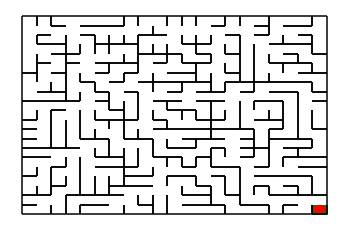

Maze of size (21, 21)


In [7]:
import numpy as np
from queue import PriorityQueue
from Maze import Maze
def my_search(maze):
    """
    任选深度优先搜索算法、最佳优先搜索（A*)算法实现其中一种
    :param maze: 迷宫对象
    :return :到达目标点的路径 如：["u","u","r",...]
    """

    start = (0,0)
    maze_size = maze.maze_size
    goal = (maze_size-1,maze_size-1)


    directions = [(-1, 0), (0, 1), (1, 0), (0, -1)]
    direction_dict = ['u','r','d','l']
    costs = [1, 1, 1, 1]

    def heuristic(node):
        return np.abs(node[0] - goal[0]) + np.abs(node[1] - goal[1])

    frontier = PriorityQueue()
    frontier.put((0,start))
    came_from = {}
    cost_so_far = {}
    came_from[start] = None
    cost_so_far[start] = 0

    while not frontier.empty():
        current = frontier.get()[1]
        

        for i in range(len(directions)):
            direction = directions[i]
            new_node = (current[0]+direction[0],current[1]+direction[1])

            if 0 <= new_node[0] < maze_size and 0 <= new_node[1] < maze_size:
                new_cost = cost_so_far[current] + costs[i]

                if not maze.is_hit_wall(current, direction_dict[i]) and (new_node not in cost_so_far or new_cost < cost_so_far[new_node]):
                    cost_so_far[new_node] = new_cost
                    priority = new_cost + heuristic(new_node)
                    frontier.put((priority, new_node))
                    came_from[new_node] = current

        if current == goal:
            # print("goal reached!")
            break

    # reverse from goal and build path
    path_point = []
    path = []
    current = goal
    while current != start:
        path_point.append(current)
        try:
            current = came_from[current]
        except KeyError as ret:
            raise ret
            return []
    path_point.append(start)
    path_point.reverse()

    last_point = None
    for point in path_point:
        if last_point is not None:
            current_dir = (point[0] - last_point[0], point[1] - last_point[1])
            d = 0
            for d in range(len(directions)):
                if current_dir == directions[d]:
                    break
            path.append(direction_dict[d])

        last_point = point
    
    return path


maze = Maze(maze_size=21) # 从文件生成迷宫

path_2 = my_search(maze)
print("搜索出的路径：", path_2)

for action in path_2:
    maze.move_robot(action)
    

if maze.sense_robot() == maze.destination:
    print("恭喜你，到达了目标点")

print(maze)

强化学习算法：使用DQN算法

action:r, reward:1.00, loc:(0, 1)
action:r, reward:1.00, loc:(0, 2)
action:r, reward:10.00, loc:(0, 3)
action:d, reward:1.00, loc:(1, 3)
action:d, reward:1.00, loc:(2, 3)
action:d, reward:1.00, loc:(3, 3)
action:d, reward:10.00, loc:(4, 3)
action:r, reward:-75.00, loc:(4, 4)
success


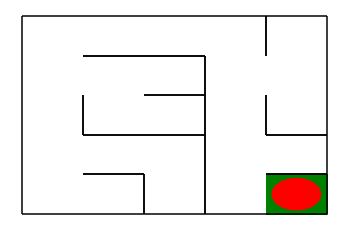

Maze of size (5, 5)


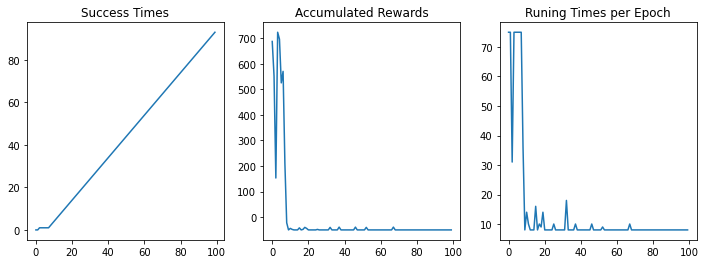

In [9]:
import numpy as np
import random

import torch
import torch.nn.functional as F
from torch import optim

from QRobot import QRobot
from Maze import Maze
from ReplayDataSet import ReplayDataSet
from torch_py.QNetwork import QNetwork

class Robot(QRobot):
    valid_action = ['u', 'r', 'd', 'l']

    ''' QLearning parameters'''
    epsilon = 1  # 初始贪心算法探索概率
    gamma = 0.9  # 公式中的 γ
    epsilon_decay = 0.98  # 每次更新衰减率

    EveryUpdate = 1  # the interval of target model's updating
    EveryUpdateTarget = 10
    
    learning_rate = 2e-2
    """some parameters of neural network"""
    target_model = None
    eval_model = None
    batch_size = 32
    # learning_rate = 2e-2
    TAU = 1e-3
    step = 1  # 记录训练的步数

    """setting the device to train network"""
    device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

    def __init__(self, maze):
        """
        初始化 Robot 类
        :param maze:迷宫对象
        """
        super(Robot, self).__init__(maze)
        maze.set_reward(reward={
            "hit_wall": 10.,
            "destination": -maze.maze_size**2 * 3.,
            "default": 1,
        })
        self.maze = maze
        self.maze_size = maze.maze_size
        
        self.epsilon = self.epsilon
        self.gamma = self.gamma
        
        self.epsilon_decay = self.epsilon_decay
        self.batch_size = pow(2, int(self.maze_size/2 + 3)) 
        if self.batch_size > 256:
            self.batch_size = 256
        self.learning_rate = self.learning_rate / self.maze_size 
        

        """build network"""
        self.target_model = None
        self.eval_model = None
        self._build_network()

        """create the memory to store data"""
        max_size = max(self.maze_size ** 2 * 3, 1e4)
        self.memory = ReplayDataSet(max_size=max_size)
        self.memory.build_full_view(maze)

    def _build_network(self):
        seed = 0
        random.seed(seed)

        """build target model"""
        self.target_model = QNetwork(state_size=2, action_size=4, seed=seed).to(self.device)

        """build eval model"""
        self.eval_model = QNetwork(state_size=2, action_size=4, seed=seed).to(self.device)

        """build the optimizer"""
        self.optimizer = optim.Adam(self.eval_model.parameters(), lr=self.learning_rate)
        # self.optimizer = optim.SGD(self.eval_model.parameters(), lr=self.learning_rate)

    def target_replace_op(self):
        """
            Soft update the target model parameters.
            θ_target = τ*θ_local + (1 - τ)*θ_target
        """

        # for target_param, eval_param in zip(self.target_model.parameters(), self.eval_model.parameters()):
        #     target_param.data.copy_(self.TAU * eval_param.data + (1.0 - self.TAU) * target_param.data)

        """ replace the whole parameters"""
        self.target_model.load_state_dict(self.eval_model.state_dict())

    def _choose_action(self, state):
        state = np.array(state)
        state = torch.from_numpy(state).float().to(self.device)
        if random.random() < self.epsilon:
            action = random.choice(self.valid_action)
        else:
            self.eval_model.eval()
            with torch.no_grad():
                q_next = self.eval_model(state).cpu().data.numpy()  # use target model choose action
            self.eval_model.train()

            action = self.valid_action[np.argmin(q_next).item()]
        return action

    def _learn(self, batch: int = 16):
        if len(self.memory) < batch:
            print("the memory data is not enough")
            return
        state, action_index, reward, next_state, is_terminal = self.memory.random_sample(batch)

        """ convert the data to tensor type"""
        state = torch.from_numpy(state).float().to(self.device)
        action_index = torch.from_numpy(action_index).long().to(self.device)
        reward = torch.from_numpy(reward).float().to(self.device)
        next_state = torch.from_numpy(next_state).float().to(self.device)
        is_terminal = torch.from_numpy(is_terminal).int().to(self.device)

        self.eval_model.train()
        self.target_model.eval()

        """Get max predicted Q values (for next states) from target model"""
        Q_targets_next = self.target_model(next_state).detach().min(1)[0].unsqueeze(1)

        """Compute Q targets for current states"""
        Q_targets = reward + self.gamma * Q_targets_next * (torch.ones_like(is_terminal) - is_terminal)

        """Get expected Q values from local model"""
        self.optimizer.zero_grad()
        Q_expected = self.eval_model(state).gather(dim=1, index=action_index)

        """Compute loss"""
        loss = F.mse_loss(Q_expected, Q_targets)
        loss_item = loss.item()

        """ Minimize the loss"""
        loss.backward()
        self.optimizer.step()

        """copy the weights of eval_model to the target_model"""
        if self.step % (self.EveryUpdateTarget) == 0:
            self.target_replace_op()
        return loss_item

    def train_update(self):
        state = self.sense_state()
        action = self._choose_action(state)
        reward = self.maze.move_robot(action)
        next_state = self.sense_state()
        is_terminal = 1 if next_state == self.maze.destination or next_state == state else 0

        self.memory.add(state, self.valid_action.index(action), reward, next_state, is_terminal)
        
        # if is_terminal:
        #     self.epsilon = 0.2
        
        """--间隔一段时间更新target network权重--"""
        if self.step % self.EveryUpdate == 0:
            # self._learn(batch=32)
            loss = self._learn(batch=self.batch_size)
            # print("step:%d, loss:%.2f" % (self.step, loss))
            # print(loss)

        """---update the step and epsilon---"""
        self.step += 1
        # self.epsilon = max(0.01, self.epsilon * 0.995)
        self.epsilon = max(0.01, self.epsilon * self.epsilon_decay)
        # print(self.epsilon)
        

        return action, reward

    def test_update(self):
        state = np.array(self.sense_state(), dtype=int)
        state = torch.from_numpy(state).float().to(self.device)

        self.eval_model.eval()
        with torch.no_grad():
            q_value = self.eval_model(state).cpu().data.numpy()

        action = self.valid_action[np.argmin(q_value).item()]
        reward = self.maze.move_robot(action)
        return action, reward


from QRobot import QRobot
from Maze import Maze
from Runner import Runner
from torch_py.MinDQNRobot import MinDQNRobot

"""  Deep Qlearning 算法相关参数： """

epoch = 100  # 训练轮数
maze_size = 5 # 迷宫size
training_per_epoch=int(maze_size * maze_size * 3)

""" 使用 DQN 算法训练 """

g = Maze(maze_size=maze_size)
myrobot = Robot(g)
# myrobot = MinDQNRobot(g)
# myrobot.memory.build_full_view(g)
runner = Runner(myrobot)
runner.run_training(epoch, training_per_epoch)

# # 生成训练过程的gif图, 建议下载到本地查看；也可以注释该行代码，加快运行速度。
# runner.generate_gif(filename="results/dqn_size10.gif")

"""Test Robot"""    
myrobot.reset()
for _ in range(25):
    a, r = myrobot.test_update()
    loc = myrobot.maze.robot['loc']
    print("action:%s, reward:%.2f, loc:%s" % (a, r, loc))
    if myrobot.maze.robot['loc'] == myrobot.maze.destination:
        print("success")
        break

print(g)
runner.plot_results()


注意：Maze.py中修改了reward，位于117行
对比实验：
 - 修改batch_size(8,16,32,64)
 - 修改learning_rate(0.01,0.001,0.0001)
 - 更换网络结构
 - 更换optimizer(Adam,SGD)